# MUVA 2022/23 - Imagen Médica
# Práctica 1 - Apartado 2
## Grupo 4
### Pablo Ríos, Celia García.

**Filtrado Non-Local Means** : Filtro discreto en imagen digital para la eliminación de ruido. Denoising.

*EL filtrado non-local means consiste en sustituir el valor de cada píxel por la media de los k píxeles con un vecindario más parecido al vecindario del píxel inicial. Se pide:*


## 2.1 Implementar una función de filtrado non-local means con el tamaño de vecindario como parámetro de entrada. Puede emplear la suma de diferencias cuadradas para comparar vecindarios.

In [5]:
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy.ndimage.filters as filters
from skimage.util import random_noise

from typing import List, Tuple

In [6]:
def plot_imgs(images: List[np.array], titles: List[str], title:str = '', size: Tuple = (15, 4)):

    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize= size)
    fig.suptitle(title)

    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

### 1. Leemos la imagen original

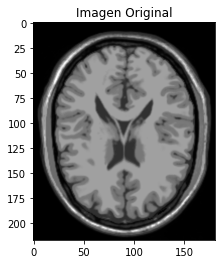

In [7]:
# Leemos la imagen
image = cv2.imread("imágenes/T1.png", cv2.COLOR_BGR2GRAY).astype(np.float64) # (217, 181)
image = image / 255.

# Visualizamos
plt.imshow(image, cmap='gray')
plt.title("Imagen Original")
plt.show()

### 2. Añadimos ruido gaussiano y s&p a la image original, para poder aplicarle el filtro NLM.


Editando los parámetros podemos modificar la cantidad de rudio que le añadimos a la imagen. Para realizar esta práctica hemos elegido estos parámetros para no añadir demasiado ruido a la imagen.

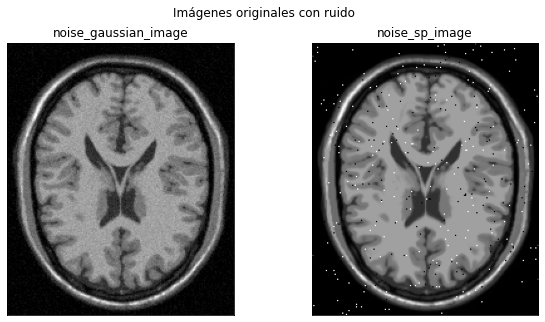

In [8]:
# Añadimos un poco de ruido

from skimage.util import random_noise
noise_sp_image = random_noise(image, mode="s&p", amount=0.01) # (217, 181)
noise_gaussian_image = random_noise(image, mode="gaussian", mean=0, var=0.001) # (217, 181)

# Visualizamos
images = [noise_gaussian_image, noise_sp_image]
titles = ['noise_gaussian_image', 'noise_sp_image']
plot_imgs(images, titles, 'Imágenes originales con ruido', (10, 5))

### 3. Implementeamos el filtro NLM


El Filtro Non-Local Means (NLM) consiste en filtrar la imagen por media ponderada de los diferentes píxeles de la imagen en función de su similitud con el píxel original.

La idea general del algoritmo Non Local Means (NLM) es detectar qué partes de mi imagen ruidosa se parecen al parche que estoy examinando, y para los parches que más se parecen, su px central es el de mi imagen filtrada.

Idealmente, la similitud de parches se busca en la imagen completa, pero como este procedimiento lleva mucho tiempo, para esta práctica se busca solo en una ventana de vecinadario, para cada píxel, definido por la variable **search_size**.


Por lo tanto, para suavizar un pixel, me recorrro toda su ventana de veciandario, centrando el parche en cada uno de los px de mi imagen ruidosa. Para cada uno de esos parches voy a calcular un peso, que es relativo a cuánto se parece ese parche con el el del px que estoy suavizando. Con la suma de diferencias cuadradas determino cuánto se parecen.

Para implementar el algoritmo, hemos seguido su forma matemática.

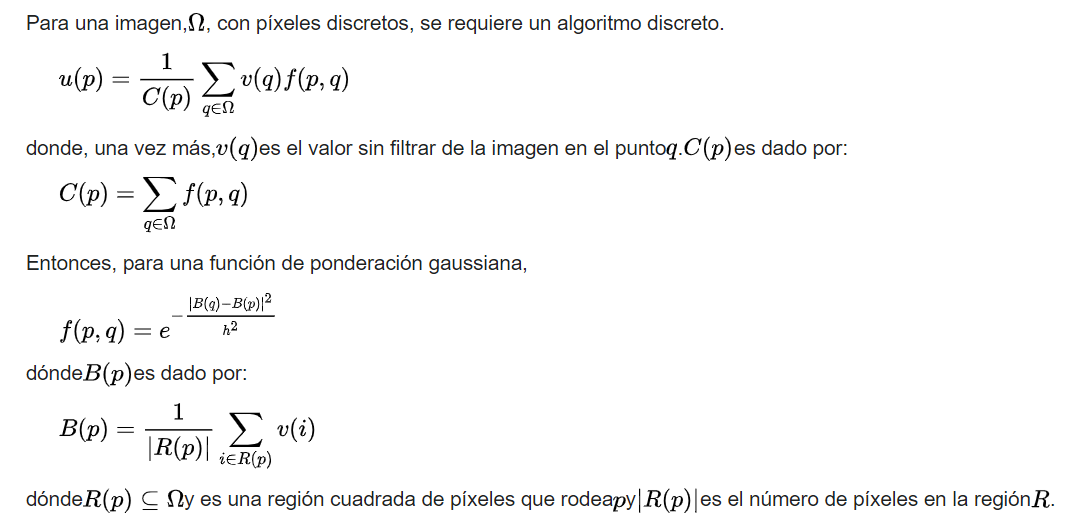

In [10]:
def NLM_filter(img, h, patch_size, search_size):
  '''
    Filtro Non Local Means,
    :param img: imagen de entrada
    :param h: Sigma. h**2 Determina el impacto de las similitudes en función de la distancia entre p y q.
      Se utiliza para controlar el peso de los valores de diferencia de parches.
    :param patch_size: tamaño del kernel, del parche
    :param search_size: tamaño de la ventana de busqueda que vamos a recorrer para aplicar los w.
    :return: Imagen filtrada
    '''
  Nw = (h**2)*(patch_size**2)
  h,w = img.shape # (217, 181)

  # Inicializamos la imagen resultante, Y.
  result_image = np.zeros(img.shape)

  # Ancho desde el px central
  search_width = search_size//2
  patch_width = patch_size//2

  # Añadimos padding para poder tener parches en los bordes de la imagen
  pad_image = np.pad(img, search_size//2, mode='reflect') # (223, 187)

  # Obtenemos todos los parches, para cada pixel q de la imagen ruidosa con padding.
  patches_q = np.zeros((pad_image.shape[0], pad_image.shape[1], patch_size, patch_size)) # (223, 187, 3, 3)
  for i in range(search_width, search_width + h):
      for j in range(search_width, search_width + w):
          patches_q[i,j] = pad_image[(i - patch_width):(i + patch_width + 1) , (j - patch_width):(j + patch_width + 1)]

  # Recorremos la ventana de busqueda, en lugar de la imagen completa.
  for i in range(search_width, search_width + h):
      for j in range(search_width, search_width + w):

          # parche para px a suavizar, i,j = p
          patch_p = patches_q[i,j] # (3,3)

          # ventana de busqueda, array de vecinadario de pix, para px p
          searchWindow_q = patches_q[(i - search_width):(i + search_width + 1) , (j - search_width):(j + search_width + 1)] # (7, 7, 3, 3)

          # Calculamos Yp, el valor del px p suavizado, usando todos los parches de los px q de la ventana de busqueda.
          Yp = evaluateNorm(patch_p, searchWindow_q, Nw)
          
          # Cliping the pixel values to stay between 0-255 
          result_image[i - search_width, j - search_width] = max(min(255, Yp), 0)

  return result_image

In [11]:
def evaluateNorm(patch_p, searchWindow_q, Nw):
    '''
    Función para calcular el valor del px suavizado, realizando ,
    :param patch_size: tamaño del parche
    :param searchWindow_q: ventana de busqueda que vamos a recorrer para aplicar los pesos.
    :param Nw: "parámetro de similitud"
    :return: Yp. Valor del pixel p suavizado de la imagen resultante (Y).
    '''
    Yp_Numerator,Z = 0,0
    # calculo Ip para px p usando px vecinos q, la ventana de busqueda de qs
    for i in range(searchWindow_q.shape[0]):
      for j in range(searchWindow_q.shape[1]):
        # parche para px q
        patch_q = searchWindow_q[i,j] # (3,3)
        # Coordinates of pixel q
        q_x,q_y = patch_q.shape[0]//2, patch_q.shape[1]//2
        # Valor de Yq, parches centrados en q.
        Yq = patch_q[q_x, q_y]

        # Calculo la similitud entre px a filtrar p y el px que se está comparando q
        # La norma **2 es la distnacia euclidea entre los dos parches, el que voy a filtrar y el que estoy comparando
        w = np.exp(-1*((np.sum((patch_p - patch_q)**2))/Nw))
        # Sumatorio de todos los parches centrados en q, aplicando un peso a cada uno. Mas peso cuanto mas se parece. 
        Yp_Numerator = Yp_Numerator + (w*Yq)
        
        Z = Z + w # Sumatorio
        Yp = Yp_Numerator/Z # /Z para ra normnalizar el valor final. Dividimos entre el sum para no afectar a la E de mi imagen.

    return Yp


### 4. Aplicamos el filtro NLM a la imagen con ruido

In [25]:
# Parámetros de entrada
h = 0.1 # Sigma. Parámetro de Similitud, asociado al grado de filtrado.
patch_size = 3 # Tamaño del parche.
search_size = 7 # Tamaño de la ventana de busqueda que voy a recorrer para sumar todos los parches con sus pesos.

In [26]:
# Denoising noise_gaussian_image
start = time.time()
denoising_image_gaussian = NLM_filter(noise_gaussian_image, h, patch_size, search_size)
end = time.time()
print(f"Tiempo que tarda nuestro filtro NLM, para noise_gaussian_image: {end-start:.2f}s\n")

# Denoising noise_sp_image
start = time.time()
denoising_image_sp = NLM_filter(noise_sp_image, h, patch_size, search_size)
end = time.time()
print(f"Tiempo que tarda nuestro filtro NLM, para noise_sp_image: {end-start:.2f}s\n")

Tiempo que tarda nuestro filtro NLM, para noise_gaussian_image: 21.55s

Tiempo que tarda nuestro filtro NLM, para noise_sp_image: 25.78s



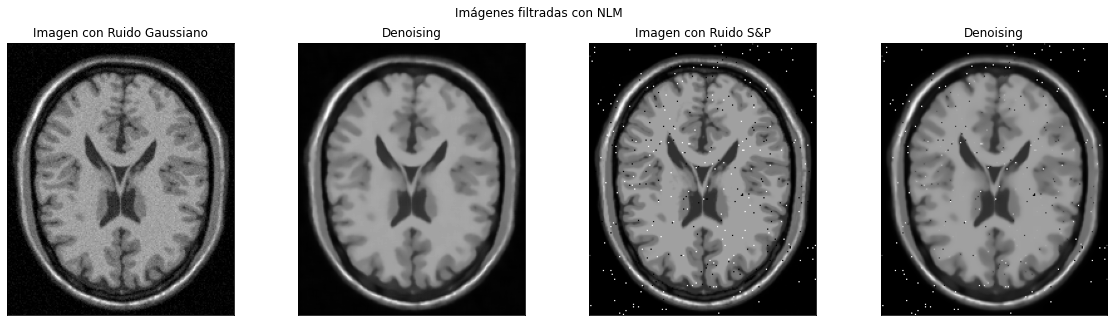

In [28]:
# Visualizo
images = [noise_gaussian_image, denoising_image_gaussian, noise_sp_image, denoising_image_sp]
titles = ['Imagen con Ruido Gaussiano', 'Denoising', 'Imagen con Ruido S&P', 'Denoising']
plot_imgs(images, titles, 'Imágenes filtradas con NLM', (20, 5))

### 5. Resultados.

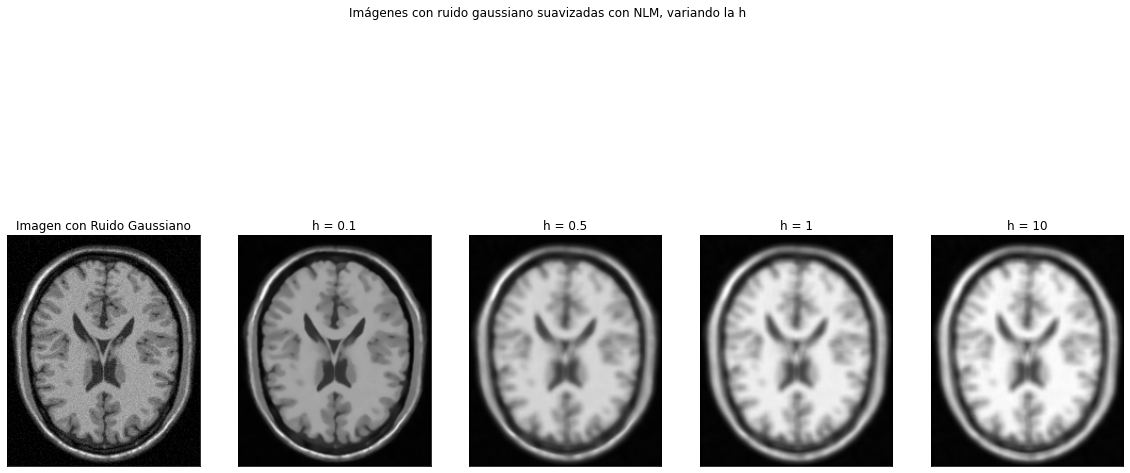

In [29]:
# Variamos el parámetro h, para filtrar imagen con ruido gausiano
patch_size = 3
search_size = 7
denoising_image_gauss_01 = NLM_filter(noise_gaussian_image, 0.1, patch_size, search_size)
denoising_image_gauss_05 = NLM_filter(noise_gaussian_image, 0.5, patch_size, search_size)
denoising_image_gauss_1 = NLM_filter(noise_gaussian_image, 1, patch_size, search_size)
denoising_image_gauss_10 = NLM_filter(noise_gaussian_image, 10, patch_size, search_size)

# Visualizo
images = [noise_gaussian_image, denoising_image_gauss_01, denoising_image_gauss_05, denoising_image_gauss_1, denoising_image_gauss_10]
titles = ['Imagen con Ruido Gaussiano', 'h = 0.1', 'h = 0.5', 'h = 1', 'h = 10']
plot_imgs(images, titles, 'Imágenes con ruido gaussiano suavizadas con NLM, variando la h', (20, 10))

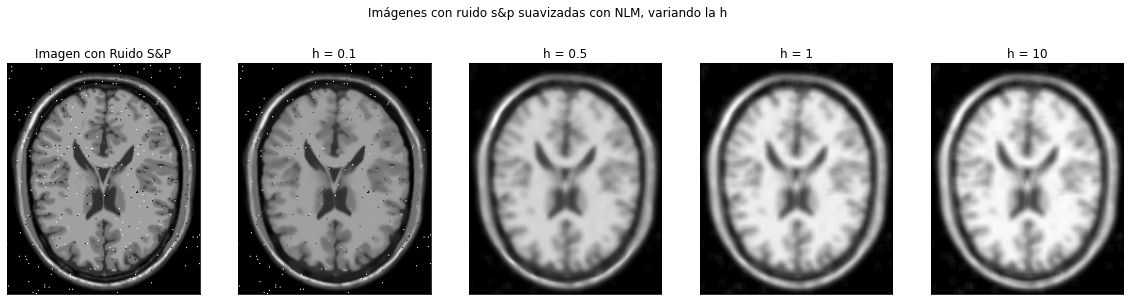

In [30]:
# Variamos el parámetro h, para filtrar imagen con ruido s&p
patch_size = 3
search_size = 7
denoising_image_sp_01 = NLM_filter(noise_sp_image, 0.1, patch_size, search_size)
denoising_image_sp_05 = NLM_filter(noise_sp_image, 0.5, patch_size, search_size)
denoising_image_sp_1 = NLM_filter(noise_sp_image, 1, patch_size, search_size)
denoising_image_sp_10 = NLM_filter(noise_sp_image, 10, patch_size, search_size)


# Visualizo
images = [noise_sp_image, denoising_image_sp_01, denoising_image_sp_05, denoising_image_sp_1, denoising_image_sp_10]
titles = ['Imagen con Ruido S&P', 'h = 0.1', 'h = 0.5', 'h = 1', 'h = 10']
plot_imgs(images, titles, 'Imágenes con ruido s&p suavizadas con NLM, variando la h', (20, 5))

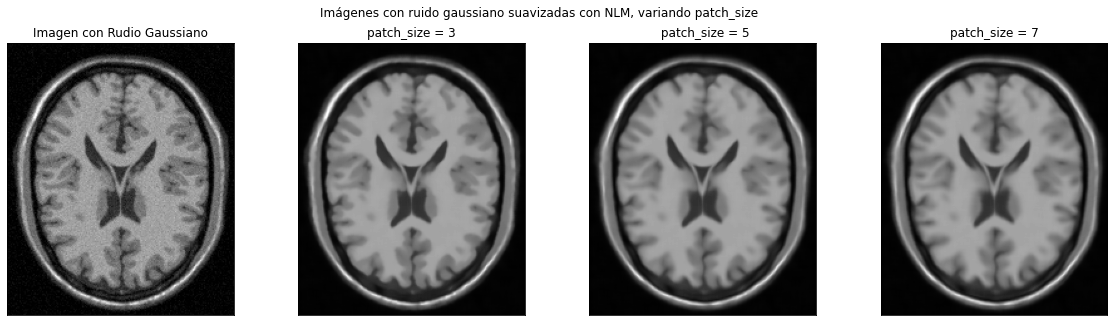

In [31]:
# Variamos el parámetro patch_size para filtrar imagen con ruido gausiano
# Variamos el tamaño del parche alrededor del píxel que se quiere comparar
h=0.1
search_size = 7
denoising_image_gauss_3 = NLM_filter(noise_gaussian_image, h, 3, search_size)
denoising_image_gauss_5 = NLM_filter(noise_gaussian_image, h, 5, search_size)
denoising_image_gauss_7 = NLM_filter(noise_gaussian_image, h, 7, search_size)

# Visualizo
images = [noise_gaussian_image, denoising_image_gauss_3, denoising_image_gauss_5, denoising_image_gauss_7]
titles = ['Imagen con Rudio Gaussiano', 'patch_size = 3', ' patch_size = 5', 'patch_size = 7']
plot_imgs(images, titles, 'Imágenes con ruido gaussiano suavizadas con NLM, variando patch_size', (20, 5))

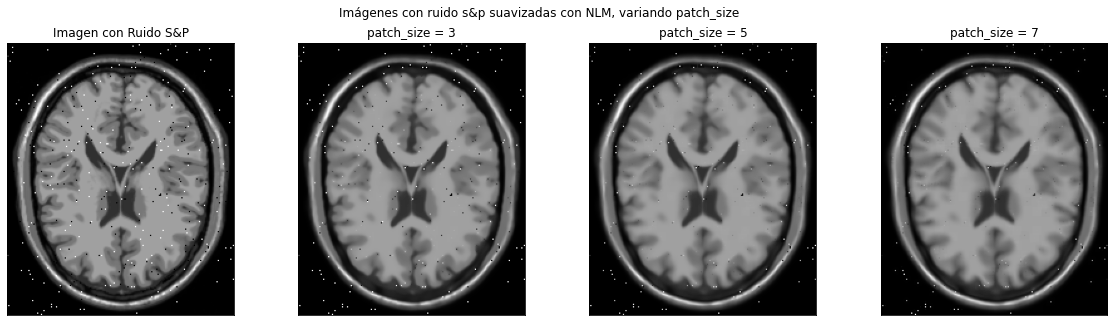

In [32]:
# Variamos el parámetro patch_size para filtrar imagen con ruido s&p
h=0.1
search_size = 7
denoising_image_sp_3 = NLM_filter(noise_sp_image, h, 3, search_size)
denoising_image_sp_5 = NLM_filter(noise_sp_image, h, 5, search_size)
denoising_image_sp_7 = NLM_filter(noise_sp_image, h, 7, search_size)

# Visualizo
images = [noise_sp_image, denoising_image_sp_3, denoising_image_sp_5, denoising_image_sp_7]
titles = ['Imagen con Ruido S&P', 'patch_size = 3', 'patch_size = 5', 'patch_size = 7']
plot_imgs(images, titles, 'Imágenes con ruido s&p suavizadas con NLM, variando patch_size', (20, 5))

Tiempo con search_size = 7: 24.52s

Tiempo con search_size = 15: 109.25s

Tiempo con search_size = 35: 580.60s



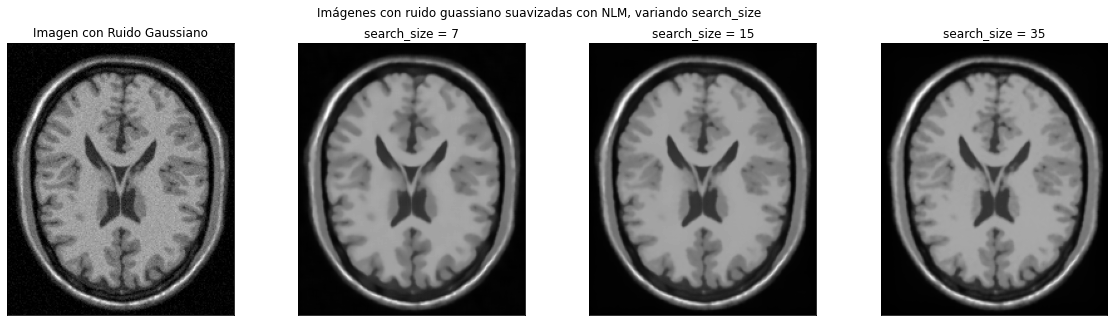

In [33]:
# Variamos el parámetro search_size para filtrar imagen con ruido gaussiano
h=0.1
patch_size = 3
start = time.time()
denoising_image_gauss_7 = NLM_filter(noise_gaussian_image, h, patch_size, 7)
end = time.time()
print(f"Tiempo con search_size = 7: {end-start:.2f}s\n")

start = time.time()
denoising_image_gauss_15 = NLM_filter(noise_gaussian_image, h, patch_size, 15)
end = time.time()
print(f"Tiempo con search_size = 15: {end-start:.2f}s\n")


start = time.time()
denoising_image_gauss_35 = NLM_filter(noise_gaussian_image, h, patch_size, 35)
end = time.time()
print(f"Tiempo con search_size = 35: {end-start:.2f}s\n")

# Visualizo
images = [noise_gaussian_image, denoising_image_gauss_7, denoising_image_gauss_15, denoising_image_gauss_35]
titles = ['Imagen con Ruido Gaussiano', 'search_size = 7', 'search_size = 15', 'search_size = 35']
plot_imgs(images, titles, 'Imágenes con ruido guassiano suavizadas con NLM, variando search_size', (20, 5))

Tiempo con search_size = 7: 22.61s

Tiempo con search_size = 15: 123.30s

Tiempo con search_size = 35: 601.08s



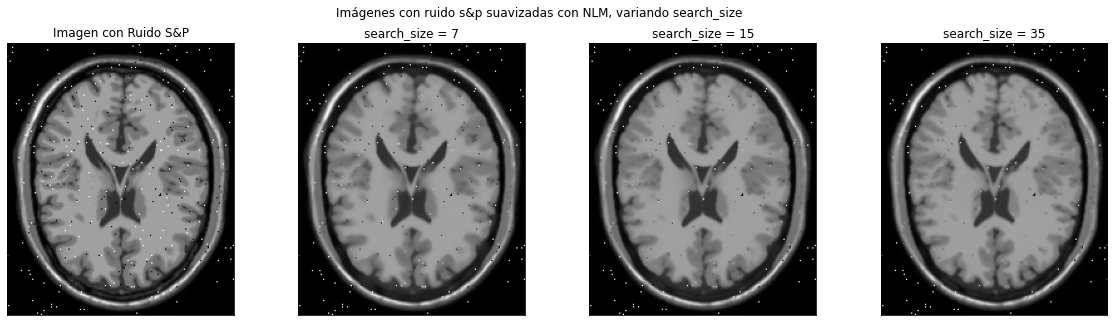

In [34]:
# Variamos el parámetro search_size para filtrar imagen con ruido s&p
h=0.1
patch_size = 3

start = time.time()
denoising_image_sp_7 = NLM_filter(noise_sp_image, h, patch_size, 7)
end = time.time()
print(f"Tiempo con search_size = 7: {end-start:.2f}s\n")

start = time.time()
denoising_image_sp_15 = NLM_filter(noise_sp_image, h, patch_size, 15)
end = time.time()
print(f"Tiempo con search_size = 15: {end-start:.2f}s\n")

start = time.time()
denoising_image_sp_35 = NLM_filter(noise_sp_image, h, patch_size, 35)
end = time.time()
print(f"Tiempo con search_size = 35: {end-start:.2f}s\n")

# Visualizo
images = [noise_sp_image, denoising_image_sp_7, denoising_image_sp_15, denoising_image_sp_35]
titles = ['Imagen con Ruido S&P', 'search_size = 7', 'search_size = 15', 'search_size = 35']
plot_imgs(images, titles, 'Imágenes con ruido s&p suavizadas con NLM, variando search_size', (20, 5))

**Conclusiones:**


*   En cuanto al parámetro h, a medida que aumenta elimina mejor el ruido pero la imagen queda más emborronada. No se preservan los bordes. Por lo tanto no interesa escoger una h alta. Nos quedamos con h = 0.1.

*   En cuanto a patch_size, a medida que se aumenta el tamaño del patch se elimina más el ruido, es decir, se suaviza más, sobretodo se ve mejor con el ruido S&P. Sin emabrgo, los bordes se vuelven mas emborronados, por lo que tampoco nos interesa poner un patch_size alto. Nos quedamos con tamaño 3x3.

*   En cuanto a search_size, a medida que lo aumentamos, mejoran los resultados, sobretodo se aprecia en los bordes y los detalles. Cuanto más grande, estoy comparando mi parche con más parches, por lo que tengo mas información. Aunque con el ruido S&P no se aprecia tanta mejora aumentando notablemente el batch_size a 35 search_size. Al ser un proceso tan costoso, conlleva mucho tiempo. 

## 2.2 Comparar el resultado de filtrar la imagen T1.png con este filtrado, un filtrado gaussiano, y el filtro de Perona-Malik.

### Filtrado Gaussiano 

Probamos aplicando el filtro gaussiano con distintios tamaños de kernel, para encontrar el kernel más óptimo en estas imágenes médicas en concreto, y compararlo con el resto.

Podemos ver como a medida que aumentamos el kernel, la imagen se va suavizando más y se ve más borrosa, emborronando los bordes. Así que para estas imágenes médicas, el kernel más apropiado es 3x3.

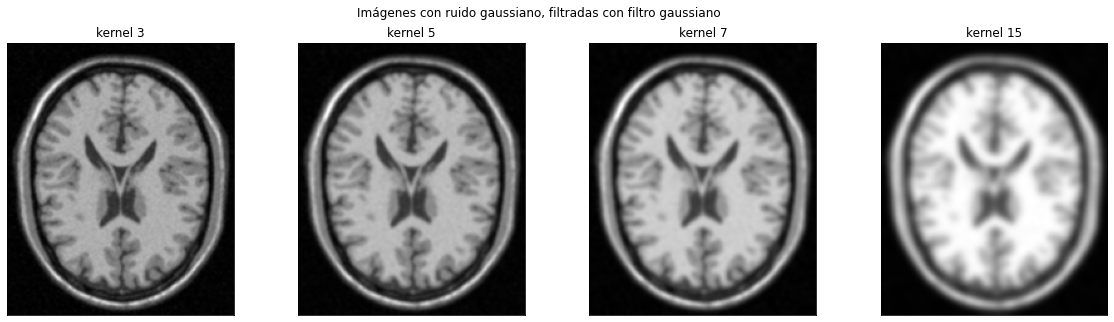

In [44]:
# Imágenes con ruido gaussiano
denoising_gaussianfilter_3 = cv2.GaussianBlur(noise_gaussian_image, (3,3),sigmaX = 0) 
denoising_gaussianfilter_5 = cv2.GaussianBlur(noise_gaussian_image, (5,5),sigmaX = 0) 
denoising_gaussianfilter_7 = cv2.GaussianBlur(noise_gaussian_image, (7,7),sigmaX = 0) 
denoising_gaussianfilter_15 = cv2.GaussianBlur(noise_gaussian_image, (15,15),sigmaX = 0) 
# Visualizamos
images = [denoising_gaussianfilter_3, denoising_gaussianfilter_5, denoising_gaussianfilter_7, denoising_gaussianfilter_15]
titles = ['kernel 3', 'kernel 5', 'kernel 7', 'kernel 15']
plot_imgs(images, titles, 'Imágenes con ruido gaussiano, filtradas con filtro gaussiano', (20, 5))



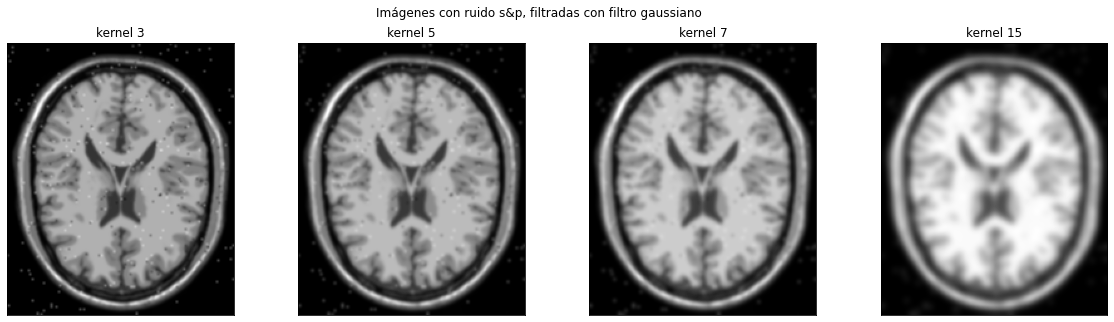

In [43]:
# Imágenes con ruido s&p
denoising_gaussianfilter_3 = cv2.GaussianBlur(noise_sp_image, (3,3),sigmaX = 0) 
denoising_gaussianfilter_5 = cv2.GaussianBlur(noise_sp_image, (5,5),sigmaX = 0) 
denoising_gaussianfilter_7 = cv2.GaussianBlur(noise_sp_image, (7,7),sigmaX = 0) 
denoising_gaussianfilter_15 = cv2.GaussianBlur(noise_sp_image, (15,15),sigmaX = 0) 
# Visualizamos
images = [denoising_gaussianfilter_3, denoising_gaussianfilter_5, denoising_gaussianfilter_7, denoising_gaussianfilter_15]
titles = ['kernel 3', 'kernel 5', 'kernel 7', 'kernel 15']
plot_imgs(images, titles, 'Imágenes con ruido s&p, filtradas con filtro gaussiano', (20, 5))

### Filtraod Perona Malik

### Comparamos los filtros

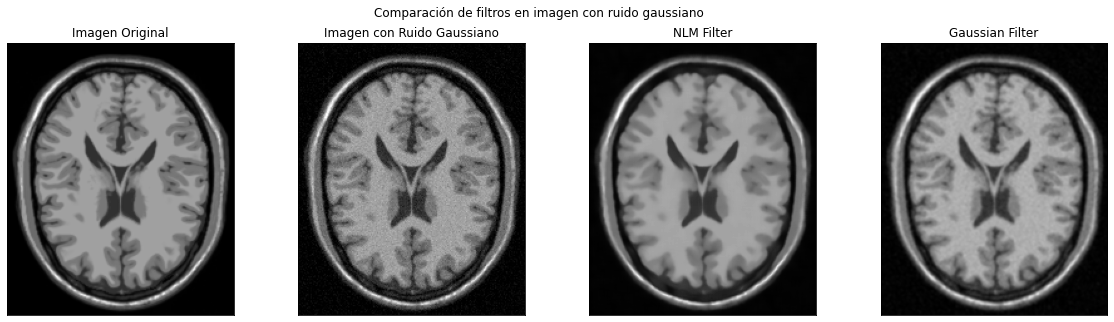

In [42]:
denoising_nlmfilter = NLM_filter(noise_gaussian_image, h = 0.1, patch_size = 3, search_size = 7)
denoising_gaussianfilter = cv2.GaussianBlur(noise_gaussian_image, (3,3),sigmaX = 0)

# Visualizamos
images = [image, noise_gaussian_image, denoising_nlmfilter, denoising_gaussianfilter]
titles = ['Imagen Original', 'Imagen con Ruido Gaussiano', 'NLM Filter', 'Gaussian Filter']
plot_imgs(images, titles, 'Comparación de filtros en imagen con ruido gaussiano', (20, 5))


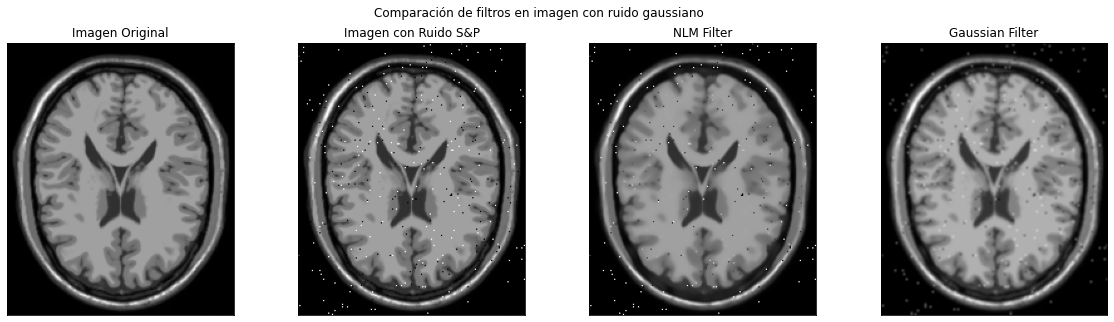

In [46]:
denoising_nlmfilter = NLM_filter(noise_sp_image, h = 0.1, patch_size = 3, search_size = 7)
denoising_gaussianfilter = cv2.GaussianBlur(noise_sp_image, (3,3),sigmaX = 0)

# Visualizamos
images = [image, noise_sp_image, denoising_nlmfilter, denoising_gaussianfilter]
titles = ['Imagen Original', 'Imagen con Ruido S&P', 'NLM Filter', 'Gaussian Filter']
plot_imgs(images, titles, 'Comparación de filtros en imagen con ruido gaussiano', (20, 5))

**Conclusiones:**

Se aprecia como el filtro gaussiano emborrona más la imagen. Esto se ve sobretodo en los bordes. Sin embargo el Filtro NLM los preserva mejor. También se ve en el ruido S&P, como los puntos blancos de ruido son mucho mas suavizados que con NLM.

El filtro Gaussiano se carga la información de los bordes porque aplica el filtro a todos los px teniendo en cuenta la información adyacente al px, por lo que en altas frecuencias se suvizan.

Sin embargo, NLM compara pixeles para ver su similitud, pero lo hace con los px de toda la imagen (o de la ventana de vecindario en este caso), no unicamente con los adyacentes a ese px. No trata información local, ahí está la diferencia.